## **Import Libraries**

In [ ]:
# %pip install mlxtend --upgrade
# %pip install pyLDAvis
import math
import pandas as pd 
import numpy as np
from numpy import concatenate
import re
from urllib import request
from pprint import pprint 

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils import shuffle
from sklearn.cluster import KMeans 
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.decomposition  import PCA
from sklearn.metrics import cohen_kappa_score
from sklearn.manifold import TSNE

import scipy.cluster.hierarchy as shc
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# nltk 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ginsim
import gensim
import gensim.corpora as corpora
import gensim.utils as simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
import gensim.downloader as api
import spacy
import scipy

# Plotting tools
#import pyLDAvis
#import pyLDAvis.gensim_models as genisvis
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
%matplotlib inline

In [2]:
# !pip uninstall numpy
# !pip uninstall pandas

# !pip install --user numpy
# !pip install --user  pandas

In [3]:
nltk.download("stopwords")
nltk.download("wordnet")
print(stopwords.words('english'))
import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'ov

True

## **Preprocessing**

In [4]:
def removes_stopwords(texts):
  stop_words = stopwords.words('english')
  return [word for word in gensim.utils.simple_preprocess(str(texts)) if word not in stop_words]


def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count = 5, threshold = 100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count = 5, threshold = 100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold = 100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return [trigram_mod[bigram_mod[doc]] for doc in texts]    

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [5]:
#  1- Politics Title: Democracy In America   Author: Alexis de Toqueville
url1 = "https://www.gutenberg.org/cache/epub/815/pg815.txt" 
#  2- History  Title: The History Of The Decline And Fall Of The Roman Empire  Author: Edward Gibbon
url2 = "https://www.gutenberg.org/cache/epub/2449/pg2449.txt"   
#  3- Sports   Title: Three Hundred Things a Bright Boy Can Do   Author: Anonymous
url3 = "https://www.gutenberg.org/cache/epub/66346/pg66346.txt"   
#  4- Food     Title: Science in the Kitchen    Author: Mrs. E. E. Kellogg
url4 = "https://www.gutenberg.org/files/61719/61719-0.txt"   
#  5- Computer and Tech  Title: The New Hacker's Dictionary  Author:  Various editors
url5 = "https://www.gutenberg.org/cache/epub/38/pg38.txt"       

urls = [url1 ,url2 ,url3, url4 ,url5]

Books_names = ["Democracy In America" ,
               "The History Of The Decline And Fall Of The Roman Empire" ,
               "Three Hundred Things a Bright Boy Can Do"  ,
               "Science in the Kitchen" ,
               "An Old-fashioned Girl"]

# Books_label_num = [ '0' ,'1' ,'2', '3' ,'4']
Books_label = ['a', 'b', 'c', 'd', 'e']

Authors = ["Alexis de Toqueville" ,
           "Edward Gibbon" ,
           "Anonymous" ,
           "Mrs. E. E. Kellogg" ,
           "Louisa May Alcott"]

book = []
r = []
bg = []
for U  in urls :
  response = request.urlopen(U)
  raw = response.read().decode('utf8')
  text= re.findall(r"[a-zA-Z]{3,}", raw)
  r.append(removes_stopwords(text))
bi_grams = make_bigrams(r)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(bi_grams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
texts = data_lemmatized

# make sure that all lists contain 100 word 
Books_contents_100 = []               
for i in texts:
    l = i[0:(math.floor(len(i)/150)) * 150]
    Books_contents_100.append(l)

# combine all lists in one dataframe 
data = pd.DataFrame()
for i in range(len(Books_contents_100)):
    dic = {}
    lis =  [Books_contents_100[i][x:x+150] for x in range(0, len(Books_contents_100[i]), 150)]
    dic['index']= i  # refer to the number of the book 
    dic['Authors']= Authors[i]
    dic['title']= Books_names[i] # refer to the book name
    dic['label'] = Books_label[i]
    dic['a150_Words'] = lis # the partition of 100 words
    df_0 = pd.DataFrame(dic)
    for i in range(len(df_0)):
        df_0["a150_Words"][i] = " ".join(df_0["a150_Words"][i])
    df = df_0[:200]
    data = data.append(df)
    
data = shuffle(data)
data.head()           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,Authors,title,label,a150_Words
105,1,Edward Gibbon,The History Of The Decline And Fall Of The Rom...,b,external standard make even knowledge importan...
177,0,Alexis de Toqueville,Democracy In America,a,militia reserve state name officer consequentl...
148,2,Anonymous,Three Hundred Things a Bright Boy Can Do,c,officer sometime later receive beaux art last ...
142,0,Alexis de Toqueville,Democracy In America,a,support judicial institution naturally weak ex...
40,4,Louisa May Alcott,An Old-fashioned Girl,e,common semicolon hybrid pit thwong common less...


In [6]:
da = data.iloc[109, 4]
len(da.split())

150

## **Text Transformation**

### (1) Bag of Words

In [7]:
count_Vec= CountVectorizer()
bow = count_Vec.fit_transform(data['a150_Words'])
X_bow = bow.toarray()
bow_df = pd.DataFrame(bow.toarray(), columns=count_Vec.get_feature_names())
bow_df

,abandon,abandoning,abash,abbess,abbreviate,abbreviation,abdicate,abduct,abend,abeyance,abhor,ability,abject,able,ably,abnormal,abode,abolish,abolishe,abolition,abominable,aboriginal,abort,abound,abridge,abroad,abrupt,abruptly,absence,absent,absolute,absolutely,absolution,absorb,absorption,absque,abstain,abstract,abstraction,absurd,...,xylophone,yaba,yard,year,year_book,yearly,yearn,years_ago,yeat,yellow,yellowish,yesterday,yesterthought,yet,yiddish,yield,yoke,yolk,yoo,young,youth,youthful,yradi,yucky,yuppie,yyyy,zeal,zealot,zealous,zealously,zed,zee,zeltube,zephyr,zeroth,zigeunerkind,zion,zip,zoo,zwieback
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### (2) TFIDF

In [8]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(data['a150_Words'])
X_tfidf = tfidf.toarray()
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
tfidf_df

,abandon,abandoning,abash,abbess,abbreviate,abbreviation,abdicate,abduct,abend,abeyance,abhor,ability,abject,able,ably,abnormal,abode,abolish,abolishe,abolition,abominable,aboriginal,abort,abound,abridge,abroad,abrupt,abruptly,absence,absent,absolute,absolutely,absolution,absorb,absorption,absque,abstain,abstract,abstraction,absurd,...,xylophone,yaba,yard,year,year_book,yearly,yearn,years_ago,yeat,yellow,yellowish,yesterday,yesterthought,yet,yiddish,yield,yoke,yolk,yoo,young,youth,youthful,yradi,yucky,yuppie,yyyy,zeal,zealot,zealous,zealously,zed,zee,zeltube,zephyr,zeroth,zigeunerkind,zion,zip,zoo,zwieback
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.098278,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.077303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.034831,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.079269,0.0,

### (3) Word2Vec

In [9]:
# split our partitions to list of words
sent = data['a150_Words'].tolist()
splitted_sent = [sen.split() for sen in sent]
print(len(splitted_sent))

1000


In [10]:
# load a pre-trained word2vec-google model
#wv = api.load('word2vec-google-news-300')

In [11]:
# build our word2vec model
word_2_vec_model = Word2Vec(splitted_sent, min_count= 1, size= 150, workers=6, window= 3, sg= 1)
# save trained model
word_2_vec_model.save("word2vec.model")

In [12]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding
    
    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(splitted_sent, model=word_2_vec_model)
X_emb = np.array(vectorized_docs)
len(vectorized_docs), len(vectorized_docs[0])

(1000, 150)

### (4) LDA

In [41]:
# create dictionary
dictionary = corpora.Dictionary(data_lemmatized)
#Term document frequency
corpus = [dictionary.doc2bow(text) for text in texts]
doc_bow = [dictionary.doc2bow(text) for text in data_lemmatized] 

# 50
lda_model_50 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = 50,
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 200, 
                                           passes = 10, 
                                           alpha = 'auto',
                                           per_word_topics = True)
pred_50 = lda_model_50.inference(doc_bow)

## 30
lda_model_30 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = 30,
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100, 
                                           passes = 10, 
                                           alpha = 'auto',
                                           per_word_topics = True)
pred_30 = lda_model_30.inference(doc_bow)

## 20
lda_model_20 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = 20,
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100, 
                                           passes = 10, 
                                           alpha = 'auto',
                                           per_word_topics = True)
pred_20 = lda_model_20.inference(doc_bow)

# 5
lda_model_5 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = 5,
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100, 
                                           passes = 10, 
                                           alpha = 'auto',
                                           per_word_topics = True)
pred_20 = lda_model_5.inference(doc_bow)

## **Models**

### **(1) K-Means**

In [13]:
def build_kMeans(clusters, X_data):
  kmeans_model= KMeans(n_clusters= clusters, init='k-means++', random_state=0)
  y_pred = kmeans_model.fit_predict(X_data)
  return kmeans_model, y_pred

#### (1.1) K-means With BOW

In [14]:
bow_kmeans, bow_kmeans_pred = build_kMeans(5,X_bow)

#### (1.2) K-Means with TFIDF

In [15]:
tfidf_kmeans, tfidf_kmeans_pred = build_kMeans(5,X_tfidf)

#### (1.3) K-Means with Word2Vec

In [16]:
emb_kmeans, emb_kmeans_pred = build_kMeans(5,X_emb)

#### (1.4) K-Means with LDA

In [43]:
lda_kmeans, lda_kmeans_pred = build_kMeans(5, pred_50[0])

### **(2) Expectation Maximaziation (EM)**

In [57]:
def build_em(clusters, X_data):
  pca = PCA(n_components= 0.99)
  new_X = pca.fit_transform(X_data)
  print("shape before using PCA : ",X_data.shape)
  print("shape after using PCA : ",new_X.shape)
  print(f'the new dimension consists of {new_X.shape[1]} that represent 99% of data info '.format(new_X.shape[1]))
  gmm_model= GaussianMixture(n_components=clusters , covariance_type= "spherical" , n_init= 10 )
  y_pred= gmm_model.fit_predict(new_X)
  gmm_probability = gmm_model.predict_proba(new_X)
  return gmm_model, y_pred, gmm_probability 

#### (2.1) EM with BOW

In [58]:
bow_em, bow_em_pred, bow_em_proba = build_em(5,X_bow)

shape before using PCA :  (1000, 13496)
shape after using PCA :  (1000, 940)
the new dimension consists of 940 that represent 99% of data info 


#### (2.2) EM With TFIDF

In [59]:
tfidf_em, tfidf_em_pred, tfidf_em_proba = build_em(5,X_tfidf)

shape before using PCA :  (1000, 13496)
shape after using PCA :  (1000, 964)
the new dimension consists of 964 that represent 99% of data info 


#### (2.3) EM with Word2Vec

In [60]:
emb_em, emb_em_pred, emb_em_proba = build_em(5,X_emb)

shape before using PCA :  (1000, 150)
shape after using PCA :  (1000, 4)
the new dimension consists of 4 that represent 99% of data info 


#### (2.4) EM with LDA

In [61]:
lda_em, lda_em_pred, lda_em_proba = build_em(5,pred_50[0])

shape before using PCA :  (5, 50)
shape after using PCA :  (5, 4)
the new dimension consists of 4 that represent 99% of data info 


ValueError: ignored

### **(3) Hierarchical clustering (Agglomerative)**

In [21]:
def build_hierarchical_cluster(clusters, X_data, title):
  # plot dendogram
  plt.figure(figsize=(10, 7))  
  plt.title(title) 

  dend= shc.dendrogram(shc.linkage(X_data, method='ward'))
  agg_model= AgglomerativeClustering(n_clusters=clusters, affinity='euclidean', linkage='ward')  
  y_pred= agg_model.fit_predict(X_data)
  return agg_model, y_pred

#### (3.1) Hierarchical clustering With BOW

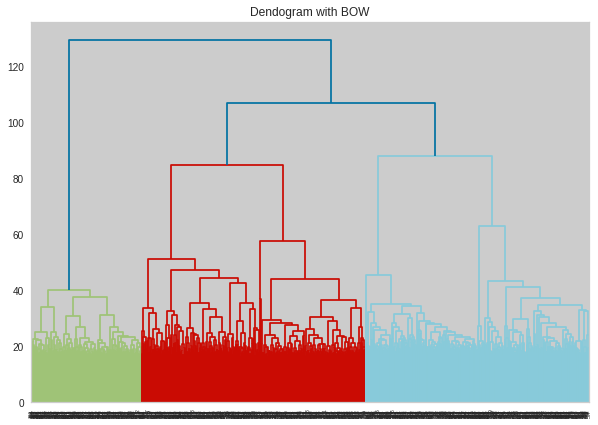

In [22]:
bow_agg, bow_agg_pred= build_hierarchical_cluster(5,X_bow,"Dendogram with BOW")

#### (3.2) Hierarchical clustering With TFIDF

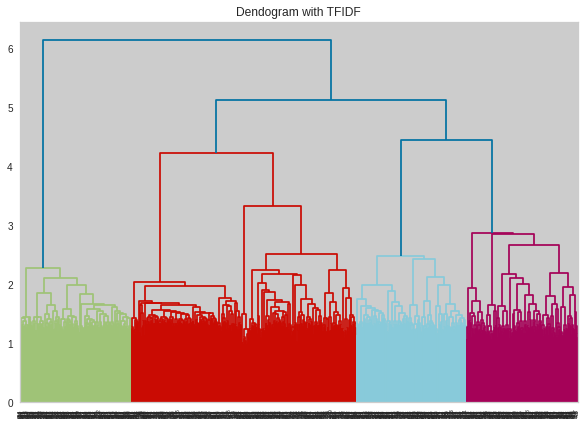

In [23]:
tfidf_agg, tfidf_agg_pred= build_hierarchical_cluster(5,X_tfidf,"Dendogram with TFIDF")

#### (3.3) Hierarchical clustering With Word2Vec

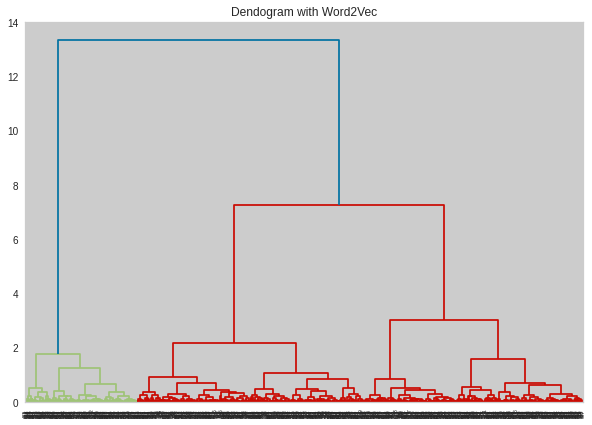

In [24]:
emb_agg, emb_agg_pred= build_hierarchical_cluster(5,X_emb,"Dendogram with Word2Vec")

#### (3.4) Hierarchical clustering With LDA

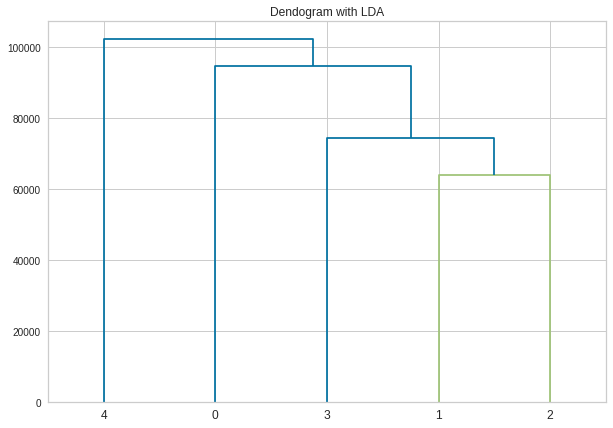

In [62]:
lda_agg, lda_agg_pred= build_hierarchical_cluster(5,pred_50[0],"Dendogram with LDA")

## **Evaluation**

### (1) Kapaa

### (2) Silhouette

In [25]:
def visualize_silhouette_kmeans(X_data, model, title):
  # Instantiate the clustering model and visualizer
  visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
  # Fit the data to the visualizer
  visualizer.fit(X_data)
  plt.title("Silhouette Score of K-means With " + title)

#### (2.1) K-means

In [54]:
print("Silhouette Score of K-means With BOW      :  {:.4f}".format(silhouette_score(X_bow,bow_kmeans_pred)))
print("Silhouette Score of K-means With TFIDF    :  {:.4f}".format(silhouette_score(X_tfidf,tfidf_kmeans_pred)))
print("Silhouette Score of K-means With Word2Vec :  {:.4f}".format(silhouette_score(X_emb,emb_kmeans_pred)))
print("Silhouette Score of K-means With LDA      :  {:.4f}".format(silhouette_score(pred_50[0],lda_kmeans_pred)))
# lda_kmeans, lda_kmeans_pred pred_50[0]

Silhouette Score of K-means With BOW      :  0.0363
Silhouette Score of K-means With TFIDF    :  0.0262
Silhouette Score of K-means With Word2Vec :  0.4494


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: ignored

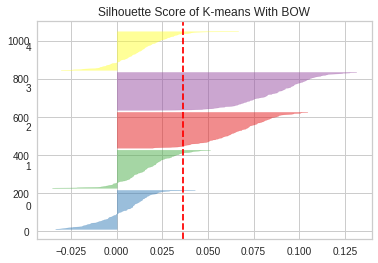

In [27]:
visualize_silhouette_kmeans(X_bow,bow_kmeans,"BOW");

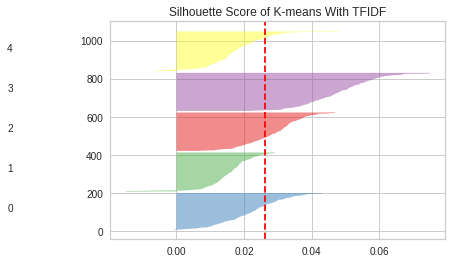

In [28]:
visualize_silhouette_kmeans(X_tfidf,tfidf_kmeans, "TFIDF");

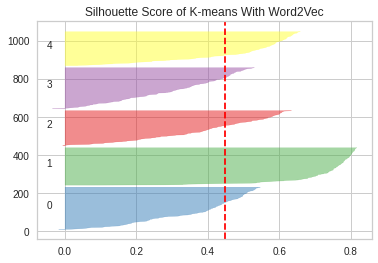

In [29]:
visualize_silhouette_kmeans(X_emb,emb_kmeans, "Word2Vec");

In [63]:
visualize_silhouette_kmeans(pred_50[0],lda_kmeans,"LDA");

ValueError: ignored

#### (2.2) Silhouette with EM

In [30]:
print("Silhouette Score of EM With BOW      :  {:.4f}".format(silhouette_score(X_bow,bow_em_pred)))
print("Silhouette Score of EM With TFIDF    :  {:.4f}".format(silhouette_score(X_tfidf,tfidf_em_pred)))
print("Silhouette Score of EM With Word2Vec :  {:.4f}".format(silhouette_score(X_emb,emb_em_pred)))
#print(f'Silhouette Score of K-means With LDA  :   {}')

Silhouette Score of EM With BOW      :  0.0293
Silhouette Score of EM With TFIDF    :  0.0262
Silhouette Score of EM With Word2Vec :  0.4445


#### (2.3) Silhouette with Hierarchical clustering

In [31]:
print("Silhouette Score of Hierarchical clustering With BOW      :  {:.4f}".format(silhouette_score(X_bow,bow_agg_pred)))
print("Silhouette Score of Hierarchical clustering With TFIDF    :  {:.4f}".format(silhouette_score(X_tfidf,tfidf_agg_pred)))
print("Silhouette Score of Hierarchical clustering With Word2Vec :  {:.4f}".format(silhouette_score(X_emb,emb_agg_pred)))

#print(f'Silhouette Score of K-means With LDA  :   {}')

Silhouette Score of Hierarchical clustering With BOW      :  0.0380
Silhouette Score of Hierarchical clustering With TFIDF    :  0.0261
Silhouette Score of Hierarchical clustering With Word2Vec :  0.4313


### (4) Coherence With LDA

## **Visualization**

### Word Cloud of each Document


 The most frequent 50 words of book: The History Of The Decline And Fall Of The Roman Empire



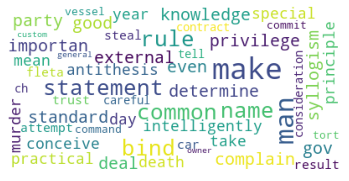


 The most frequent 50 words of book: Democracy In America



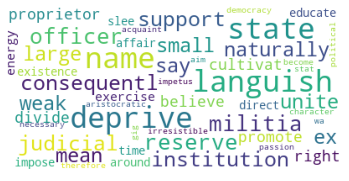


 The most frequent 50 words of book: Three Hundred Things a Bright Boy Can Do



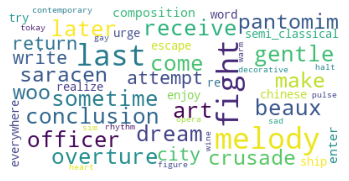


 The most frequent 50 words of book: An Old-fashioned Girl



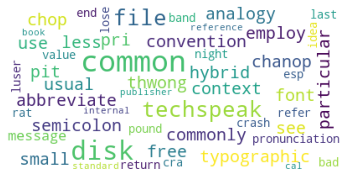


 The most frequent 50 words of book: Science in the Kitchen



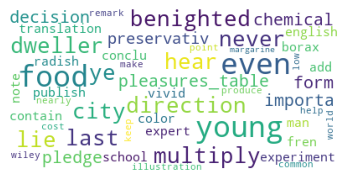

In [32]:
# plot word cloud for the most frequent 50 words in each book  
import wordcloud

for label in data['title'].unique():
  books = data[data["title"]==label]["a150_Words"]

  #wordcloud 
  print(f"\n The most frequent 50 words of book: {label}\n")
  wc = wordcloud.WordCloud(background_color='white', max_words=50, 
                          max_font_size=35)
  wc = wc.generate(str(books))
  plt.axis('off')
  plt.imshow(wc, cmap=None)
  plt.show()

### (2) Visualize Predicted Clusters

In [33]:
def visualize_cluster(cluster_model, data, y_pred, em=True):
  # get centroids of kmeans cluster
  if em:
    centroids = np.empty(shape=(cluster_model.n_components, data.shape[1]))
  else:
    centroids = cluster_model.cluster_centers_

  # we want to transform the rows and the centroids
  # todense return matrix
  all_Data = concatenate((data.todense(), centroids))

  ### define parameters
  n_clusters = 5
  # Initialization of embedding could also be 'random' {‘random’, ‘pca’}
  tsne_init = "pca"
  # the number of nearest neighbors that is used in
  # other manifold learning algorithms.
  tsne_perplexity = 30.0
  # Controls how tight natural clusters in the original space are
  # in the embedded space and how much space will be between them
  tsne_early_exaggeration = 4.0

  tsne_learning_rate = 10

  # Build TSNE model
  tsne_model = TSNE(n_components= 2,   # Dimension of the embedded space.
                    random_state= 0,  
                    init= tsne_init,
                    perplexity= tsne_perplexity,
                    early_exaggeration= tsne_early_exaggeration,
                    learning_rate= tsne_learning_rate)

  transformed_labeled_Data = tsne_model.fit_transform(all_Data)
  # print(transformed_labeled_Data)
  plt.scatter(transformed_labeled_Data[:-n_clusters, 0], transformed_labeled_Data[:-n_clusters, 1], c=y_pred, cmap=plt.cm.Paired, marker= 'x')
  plt.scatter(transformed_labeled_Data[-n_clusters:, 0], transformed_labeled_Data[-n_clusters:, 1], marker= 'o')
  plt.show()

#### (2.1) K-Means With BOW

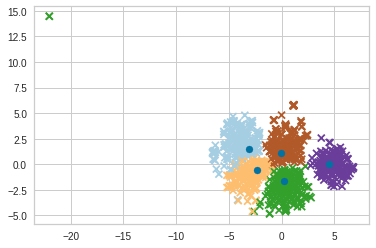

In [34]:
visualize_cluster(bow_kmeans, bow, bow_kmeans_pred,False)

#### (2.2) K-Means With TFIDF

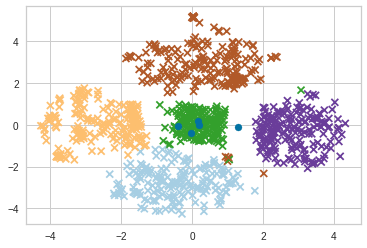

In [35]:
visualize_cluster(tfidf_kmeans, tfidf, tfidf_kmeans_pred,False)

#### (2.3) K-Means With Word2Vec

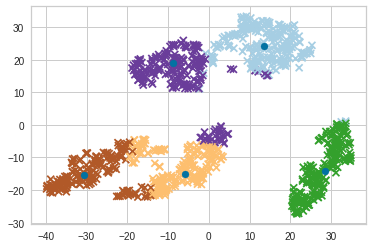

In [36]:
x_emb_matrix = csr_matrix(X_emb)
visualize_cluster(emb_kmeans, x_emb_matrix, emb_kmeans_pred,False)

#### (2.4) K-Means With LDA

#### (3.1) EM With BOW

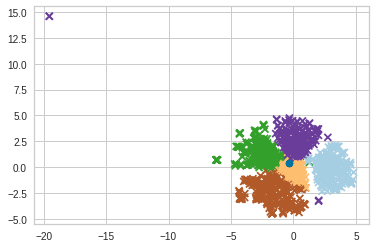

In [37]:
visualize_cluster(bow_em, bow, bow_em_pred,True)

#### (3.2) EM With TFIDF

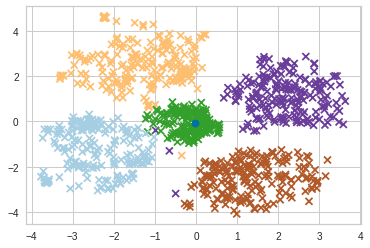

In [38]:
visualize_cluster(tfidf_em, tfidf, tfidf_em_pred,True)